# Game Recommendation System - Data Processing

A system for recommending games based on review data on Steam

## Exploratory Data Analysis

In [4]:
import numpy as np
import pandas as pd
import json
import gzip
import re
import copy
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [5]:
# data file paths
RATINGS_PATH = "data/australian_user_reviews.json"
GAME_METADATA_PATH = "data/steam_games.json.gz"
PLOTS_PATH = "plots/"

### Functions for parsing data

In [6]:
def parse_gzipped_all(path):
    """reads the gzipped input data file in path
    returns - a list of dictionaries"""
    with gzip.open(path, "r") as g:
        data = [eval(l) for l in g.readlines()]
    return data

def parse_gzipped_gen(path):
    """generator for reading the gizziped input
    file"""
    with gzip.open(path, "r") as g:
        for l in g.readlines():
            yield(eval(l))

def parse_data_all(path):
    """reads the input data file in path
    returns - a list of dictionaries"""
    with open(path, "r", errors="ignore") as f:
        data = [eval(l) for l in f.readlines()]
    return data

def parse_data_gen(path):
    """generator for reading the gizziped input
    file"""
    with open(path, "r") as f:
        for l in f.readlines():
            yield(eval(l))



### Import data

In [7]:
games = parse_gzipped_all(GAME_METADATA_PATH)

In [8]:
ratings = parse_data_all(RATINGS_PATH)

### Format data

In [9]:
# format ratings data
def format_ratings(ratings, ratings_col="reviews"):
    """returns a dataframe of user - game ratings"""
    # define a helper function for parsing a single user
    def parse_user(user_dict):
        """creates a df from a single user ratings"""
        reviews = user_dict.pop(ratings_col)
        ratings = pd.DataFrame(data=reviews)
        # add user info to ratings
        for k, v in user_dict.items():
            ratings[k] = v
        return ratings
    
    # concatenate everything
    ratings_all = pd.concat([parse_user(u) for u in ratings], sort=False)
    return ratings_all.reset_index().drop(columns="index")
    

In [10]:
ratings_df = format_ratings(ratings)

In [11]:
ratings_df

,funny,helpful,item_id,last_edited,posted,recommend,review,user_id,user_url
0,,No ratings yet,1250,,"Posted November 5, 2011.",True,Simple yet with great replayability. In my opi...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,,No ratings yet,22200,,"Posted July 15, 2011.",True,It's unique and worth a playthrough.,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,,No ratings yet,43110,,"Posted April 21, 2011.",True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,,15 of 20 people (75%) found this review helpful,251610,,"Posted June 24, 2014.",True,I know what you think when you see this title ...,js41637,http://steamcommunity.com/id/js41637
4,,0 of 1 people (0%) found this review helpful,227300,,"Posted September 8, 2013.",True,For a simple (it's actually not all that simpl...,js41637,http://steamcommunity.com/id/js41637
5,,1 of 4 people (25%) found this review helpful,239030,,"Posted November 29, 2013.",True,Very fun little game to play when your bored o...,js41637,http://steamcommunity.com/id/js41637
6,,No ratings yet,248820,,Posted February 3.,True,A suitably punishing roguelike platformer. Wi...,evcentric,http://steamcommunity.com/id/evcentric
7,,No ratings yet,370360,"Last edited December 5, 2015.","Posted December 4, 2015.",True,"""Run for fun? What the hell kind of fun is that?""",evcentric,http://steamcommunity.com/id/evcentric
8,,No ratings yet,237930,,"Posted November 3, 2014.",True,"Elegant integration of gameplay, story, world ...",evcentric,http://steamcommunity.com/id/evcentric
9,,No ratings yet,263360,,"Posted October 15, 2014.",True,"Random drops and random quests, with stat poin...",evcentric,http://steamcommunity.com/id/evcentric


In [12]:
ratings_df["recommend"] = ratings_df["recommend"].astype(int)

### Analyze full dataset

#### User/game rating density

In [13]:
def analyze_dataset(ratings, user_col="user_id", item_col="item_id"):
    """computes dataset size and density"""
    n_users = len(ratings[user_col].unique())
    n_games = len(ratings[item_col].unique())
    n_ratings = ratings.shape[0]
    density = n_ratings / (n_users * n_games)
    print("Total # of users: %i" %(n_users))
    print("Total # of games rated: %i" %(n_games))
    print("Total # of ratings: %i" %(n_ratings))
    print("Percent ratings density: %.4f" %(100 * density))
    return (n_users, n_games, n_ratings, density)
    

In [14]:
_ = analyze_dataset(ratings_df)

Total # of users: 25458
Total # of games rated: 3682
Total # of ratings: 59305
Percent ratings density: 0.0633


#### Positive/negative ratings distribution

In [17]:
def plot_ratings_distribution(ratings, col="recommend", figsize=(12,8), name="ratings_distribution.png"):
    """shows the distribution of positive and negative ratings
    in the dataset"""
    ratings_counts = ratings[col].value_counts()
    neg_r, pos_r = ratings_counts[0], ratings_counts[1]
    tot_r = pos_r + neg_r
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.countplot(x=ratings[col])
    plt.show()
    fig.savefig(PLOTS_PATH + name, dpi=fig.dpi)
    print("Percent positive ratings: %.2f" % (100 * pos_r / tot_r))
    print("Percent negative ratings: %.2f" % (100 * neg_r / tot_r))


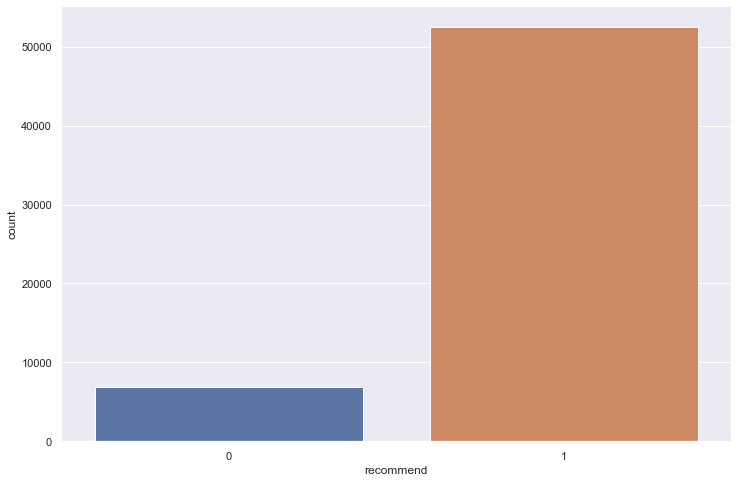

Percent positive ratings: 88.48
Percent negative ratings: 11.52


In [18]:
plot_ratings_distribution(ratings_df, name="ratings_distribution_full.png")

#### Long tail analysis

In [19]:
def plot_rating_counts(ratings, col, xlabel, log=False, name="ratings_counts.png"):
    """generates a long-tail plot for users/games"""
    counts = ratings[col].value_counts().values
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(counts)
    ax.fill_between(np.arange(len(counts)), counts, alpha=0.5)
    ax.set_xlabel(xlabel)
    if log:
        ax.set_yscale("log")
        ax.set_ylabel("log(# of ratings)")
    else:
        ax.set_ylabel("# of ratings")
    fig.savefig(PLOTS_PATH + name, dpi=fig.dpi)
    plt.show()
        

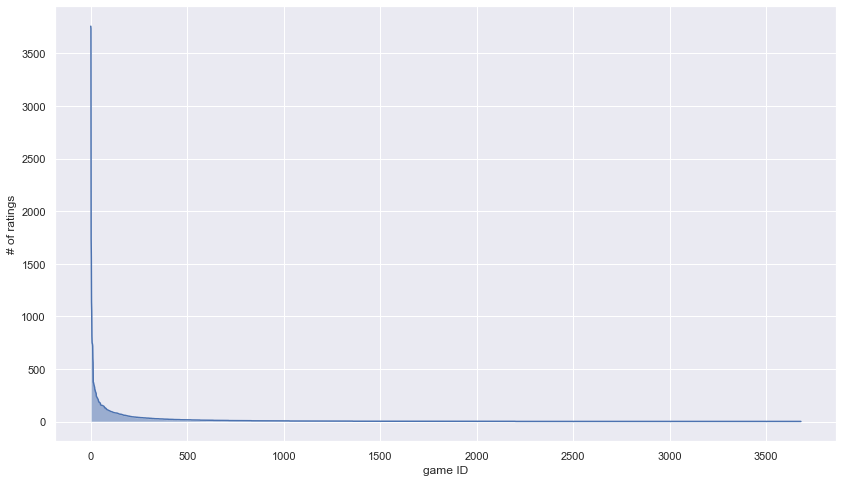

In [22]:
# Distribution of ratings for the games
plot_rating_counts(ratings_df, "item_id", "game ID", log=False, name="ratings_counts_items_full.png")

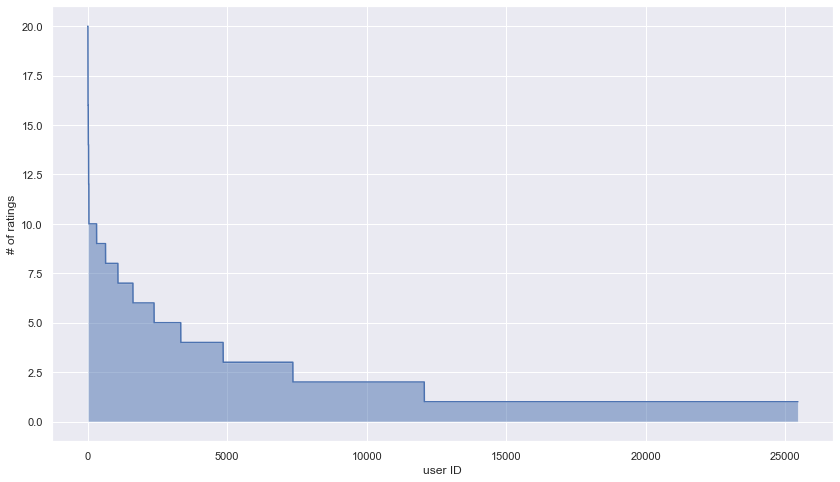

In [21]:
# Distribution of ratings for users
plot_rating_counts(ratings_df, "user_id", "user ID", log=False, name="ratings_counts_users_full.png")

### Extract k-core

In [23]:
def extract_n_core(df, n, user_col="user_id", item_col="item_id"):
    """extracts the n-core: items that have been rated by at least n-users
    and users that have rated at least n-items"""
    initial_sz = len(df)
    df = df.copy(deep=True)
    # define a helper function
    def drop_rows(df, col, n):
        """returns number of dropped rows"""
        counts = df[col].value_counts()
        drop_names = counts[counts < n].index
        drop_idxs = df[df[col].isin(drop_names)].index
        df.drop(index=drop_idxs, inplace=True)
        return len(drop_idxs)
    
    print("starting extraction...")
    # iterate over users and items untill finished
    while True:
        if df.shape[0] == 0:
            print("DataFrame empty, try lowering k")
            break
        # drop users with less than n-ratings
        dropped_users = drop_rows(df, user_col, n)
        print("dropped %i users" %(dropped_users))
        # drop items with less than n-ratings 
        dropped_items = drop_rows(df, item_col, n)
        print("dropped %i items" %(dropped_items))
        if dropped_users == 0 and dropped_items == 0:
            break
    
    final_sz = len(df)
    print("Final dataset is %.1f percent of the original size" % (100 * final_sz / initial_sz))
    return df
        

In [24]:
ratings_3k = extract_n_core(ratings_df, 3)

starting extraction...
dropped 22815 users
dropped 2286 items
dropped 785 users
dropped 83 items
dropped 40 users
dropped 4 items
dropped 0 users
dropped 0 items
Final dataset is 56.1 percent of the original size


In [58]:
ratings_3k["item_id"].value_counts()

440       1538
730       1520
4000       980
218620     670
570        617
304930     611
550        466
72850      442
252490     435
221100     404
105600     396
49520      335
230410     324
620        245
218230     233
208090     220
271590     214
1250       207
301520     191
211820     190
236390     188
224260     186
265930     182
8930       179
346110     173
107410     165
377160     164
252950     160
8870       158
244850     157
          ... 
373110       3
318230       3
251470       3
24810        3
240970       3
314020       3
205950       3
329440       3
327640       3
317470       3
209340       3
15710        3
323910       3
290890       3
288160       3
285310       3
265750       3
70600        3
21000        3
263360       3
341800       3
217920       3
63500        3
246580       3
416640       3
1930         3
18700        3
218820       3
33220        3
207620       3
Name: item_id, Length: 1346, dtype: int64

### Analyze the extracted k-core

In [25]:
_ = analyze_dataset(ratings_3k)

Total # of users: 6906
Total # of games rated: 1346
Total # of ratings: 33292
Percent ratings density: 0.3582


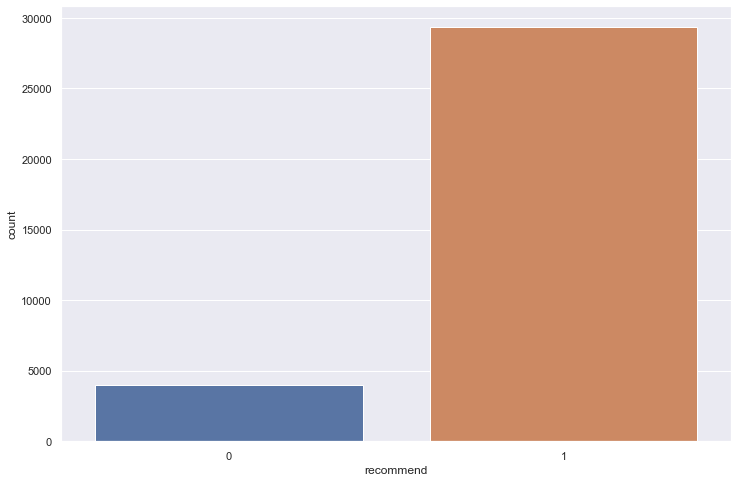

Percent positive ratings: 88.11
Percent negative ratings: 11.89


In [26]:
plot_ratings_distribution(ratings_3k, name="ratings_distribution_3k.png")

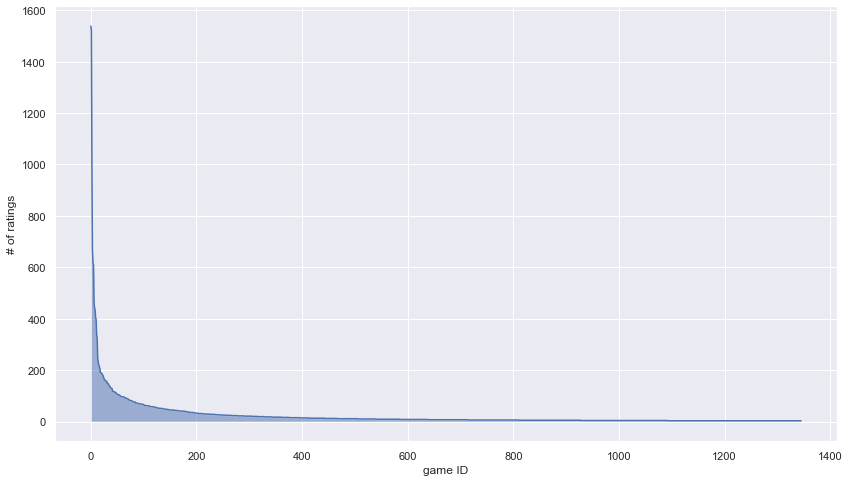

In [27]:
# Distribution of game ratings
plot_rating_counts(ratings_3k, "item_id", "game ID", log=False, name="ratings_counts_items_3k.png")

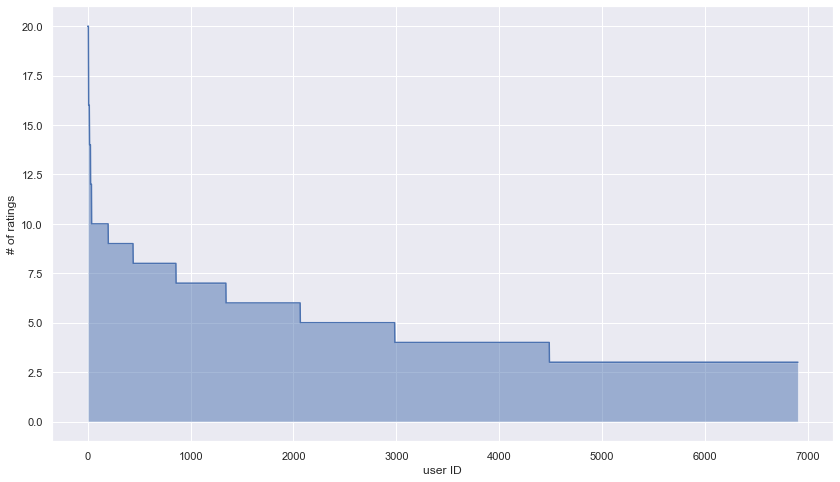

In [28]:
# Distribution of user ratings
plot_rating_counts(ratings_3k, "user_id", "user ID", log=False, name="ratings_counts_users_3k.png")

## Split data for training/testing

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
targets_3k = ratings_3k["recommend"].copy()
data_3k = ratings_3k.drop(columns="recommend").copy()

In [31]:
def recommender_split(data, targets, test_size, game_col="item_id", user_col="user_id", max_tries=100):
    """splits ratings into train/test sets such that
    every user and every game is present at least once in
    the training set"""
    items_all = len(data[game_col].unique())
    # check if minimal test size is specified
    min_test_sz = len(data[user_col].unique())
    if test_size < (min_test_sz / len(data)):
        print("Using minimal test size of %.2f" %(min_test_sz / len(data)))
        test_size = min_test_sz
        
    c = 0
    while True:
        # if reached max number of tries
        if c >= max_tries:
            print("Could not make the split. Exiting...")
            return (None, None, None, None)
        
        # increment counter
        c += 1
        # try a split
        X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            targets, 
                                                            test_size=test_size, 
                                                            stratify=data[user_col].values, 
                                                            random_state=123)
        items_train = len(X_train[game_col].unique())
        if items_train == items_all:
            print("Success!")
            return (X_train, X_test, y_train, y_test)



In [83]:
X_train_3k, X_test_3k, y_train_3k, y_test_3k = recommender_split(data_3k, targets_3k, test_size=0.25)

Success!


### Ratings distribution of the train/test sets

In [84]:
y_train_3k.value_counts(normalize=True)

1    0.879491
0    0.120509
Name: recommend, dtype: float64

In [85]:
y_test_3k.value_counts(normalize=True)

1    0.885979
0    0.114021
Name: recommend, dtype: float64

### Game/user IDs in the training set
Double-checks that no games/users were completely dropped in the training set

In [86]:
len(data_3k["item_id"].unique())

1346

In [87]:
len(X_train_3k["item_id"].unique())

1346

In [89]:
len(data_3k["user_id"].unique())

6906

In [90]:
len(X_train_3k["user_id"].unique())

6906

## Persist processed data

In [97]:
X_train_3k.to_csv("train_test_split/X_train_3k.csv")
X_test_3k.to_csv("train_test_split/X_test_3k.csv")
y_train_3k.to_csv("train_test_split/y_train_3k.csv", header=True)
y_test_3k.to_csv("train_test_split/y_test_3k.csv", header=True)